In [1]:
print('hello world')

hello world


In [66]:
from code.computations import evaluation_w2v as ev
from code.preprocessing import load_data as ld
import os
import pandas as pd
from gensim.models import Word2Vec
import optuna

In [67]:
os.chdir(r"C:/BA_thesis/BA_v2_31.03")

print(f"working directory: {os.getcwd()}")
input_path = os.getcwd() + '/files/corpus_data'

corpus = ld.TxtSubdirsCorpus("files/dfs")

working directory: C:\BA_thesis\BA_v2_31.03
Corpus active! Path: files/dfs 



In [72]:
# basic
import os
from pathlib import Path
import pandas as pd

# other files
from code.preprocessing import load_data as ld
from code.visual import visualization as vs

# case-specific
from gensim.models import Word2Vec
import statistics
from collections import defaultdict
import optuna

"""
Evaluation and piccking the best word2v3c model
"""


def evaluation_with_file(model: Word2Vec, ev_file: str):
    file_path = Path(ev_file)
    assert file_path.is_file(), f"You passed wrong file [{file_path}] in evaluation_with_file"
    result = model.wv.evaluate_word_analogies(ev_file)
    return result[0]  # accuracy


def evaluate_model(model: Word2Vec, ev_file: str, test_words: list):
    """
    Evaluate single word2vec model
    """
    acc = evaluation_with_file(model=model, ev_file=ev_file)
    similarity_scores = []
    for x in range(len(test_words)):
        w1 = test_words[x][0]
        w2 = test_words[x][1]

        if w1 in model.wv.key_to_index and w2 in model.wv.key_to_index:
            similarity_score = model.wv.similarity(*test_words[x])
            similarity_scores.append(similarity_score)
        else:
            print(f"Warning: Word {w1} or {w2} not found in the model vocabulary.")

    if similarity_scores:
        custom_sim_score = statistics.mean(similarity_scores)
    else:
        custom_sim_score = 0
        print(f"No similarity scores found for this model [{model}]. avg_score: {custom_sim_score} ")
    return custom_sim_score, acc


def find_best_params_w2v(corpus, n_trials: int):
    def train_w2v_models(trial):
        window = trial.suggest_int("window", 2, 3)
        epochs = trial.suggest_int("epochs", 100, 150)
        sg = trial.suggest_int("sg", 0, 1)
        vector_size = trial.suggest_int("vector_size", 100, 120)
        print(f'\nTraining of w{window}e{epochs}sg{sg}v{vector_size} has started.')
        
        w2v = Word2Vec(
            sentences=corpus,
            window=window,
            min_count=5,
            epochs=epochs,
            sg=sg,
            vector_size=vector_size
        )
        result = evaluate_model(w2v,
                                ev_file='files/google.txt',
                                test_words=[('good', 'bad'), ('game', 'theory')])
        return result


    study = optuna.create_study(directions=["maximize", "maximize"],
                                study_name='w2v_optimization')

    study.optimize(train_w2v_models,
                   n_trials=n_trials)

    ev_metric = study.trials_dataframe()
    ev_metric.rename(columns={'values_0': 'custom_sim_score', 'values_1': 'external_accuracy'}, inplace=True)
    ev_metric['model_name'] = (
            'w' + ev_metric['params_window'].astype(str) +
            'e' + ev_metric['params_epochs'].astype(str)  +
            'sg' + ev_metric['params_sg'].astype(str)  +
            'v' + ev_metric['params_vector_size'].astype(str) )
    return ev_metric




In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
def print_w2v_evalutaion_results(df: pd.DataFrame, external_sim_score: str, internal_sim_score: str, model_name: str):
    # the best model is the first one
    df = df.sort_values(by=[external_sim_score, internal_sim_score], ascending=False)

    ess = external_sim_score
    print(f"ess: {ess}")
    iss = internal_sim_score
    print(f"iss: {iss}")
    sns.set_theme(style="ticks")

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df,
                    x=iss,
                    y=ess,
                    hue=model_name,
                    palette="hls",
                    s=100,
                    alpha=0.8,
                    legend=False)

    best_row = df.iloc[0]
    second_row = df.iloc[1]
    third_row = df.iloc[2]

    rows = [best_row, second_row, third_row]
    for row in rows:
        plt.scatter(row[iss],
                    row[ess],
                    s=90,
                    edgecolor='black',
                    facecolor='red',
                    linewidth=1)

        plt.text(row[iss] + 0.005,
                 row[ess] - 0.0005,
                 f"{row[model_name]}",
                 fontsize=9,
                 color='black')

    plt.title("Evaluation Results", fontsize=14, fontweight="bold")
    plt.xlabel("Mean similarity score for chosen word-pairs", fontsize=12, fontweight="bold")
    plt.ylabel("Accuracy score computed with Google test-set", fontsize=12, fontweight="bold")
    # plt.legend(title="Model", loc='best', prop={'size': 8})
    plt.tight_layout()
    plt.show()

In [74]:
ev_metric = find_best_params_w2v(corpus=corpus,
                                n_trials=4)


[I 2025-04-19 20:03:23,832] A new study created in memory with name: w2v_optimization



Training of w3e109sg0v114 has started.


[I 2025-04-19 20:04:02,264] Trial 0 finished with values: [0.05367255583405495, 0.025] and parameters: {'window': 3, 'epochs': 109, 'sg': 0, 'vector_size': 114}.



Training of w3e126sg0v120 has started.


[I 2025-04-19 20:04:34,273] Trial 1 finished with values: [0.05201486498117447, 0.0] and parameters: {'window': 3, 'epochs': 126, 'sg': 0, 'vector_size': 120}.



Training of w3e125sg0v100 has started.


[I 2025-04-19 20:05:02,525] Trial 2 finished with values: [0.04415681213140488, 0.0125] and parameters: {'window': 3, 'epochs': 125, 'sg': 0, 'vector_size': 100}.



Training of w3e101sg1v101 has started.


[I 2025-04-19 20:05:40,457] Trial 3 finished with values: [0.3124766945838928, 0.0375] and parameters: {'window': 3, 'epochs': 101, 'sg': 1, 'vector_size': 101}.


In [75]:
ev_metric

,number,custom_sim_score,external_accuracy,datetime_start,datetime_complete,duration,params_epochs,params_sg,params_vector_size,params_window,system_attrs_NSGAIISampler:generation,state,model_name
0,0,0.053673,0.0250,2025-04-19 20:03:23.848014,2025-04-19 20:04:02.264002,0 days 00:00:38.415988,109,0,114,3,0,COMPLETE,w3e109sg0v114
1,1,0.052015,0.0000,2025-04-19 20:04:02.264002,2025-04-19 20:04:34.273080,0 days 00:00:32.009078,126,0,120,3,0,COMPLETE,w3e126sg0v120
2,2,0.044157,0.0125,2025-04-19 20:04:34.273080,2025-04-19 20:05:02.525070,0 days 00:00:28.251990,125,0,100,3,0,COMPLETE,w3e125sg0v100
3,3,0.312477,0.0375,2025-04-19 20:05:02.525070,2025-04-19 20:05:40.457217,0 days 00:00:37.932147,101,1,101,3,0,COMPLETE,w3e101sg1v101


ess: external_accuracy
iss: custom_sim_score


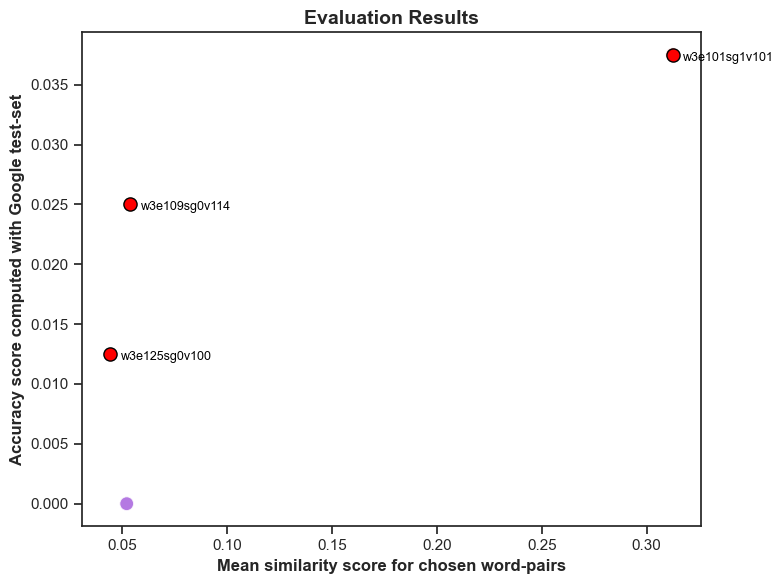

In [76]:
print_w2v_evalutaion_results(df=ev_metric,
                                    external_sim_score='external_accuracy',
                                    internal_sim_score='custom_sim_score',
                                    model_name='model_name')

In [88]:
def get_best_params(df: pd.DataFrame, external_sim_score: str, internal_sim_score: str):
    df = df.sort_values(by=[external_sim_score, internal_sim_score], ascending=False)
    best_params = df.iloc[0]
    return best_params


In [90]:
best_params = get_best_params(df=ev_metric,
                   external_sim_score='external_accuracy', 
                   internal_sim_score='custom_sim_score')
epochs = best_params['params_epochs']
sg = best_params['params_sg']
vector_size = best_params['params_vector_size']
window = best_params['params_window']

model = Word2Vec(
        sentences=corpus,
        window=window,
        min_count=5,
        epochs=epochs,
        sg=sg,
        vector_size=vector_size
        )


best params: number                                                            3
custom_sim_score                                           0.312477
external_accuracy                                            0.0375
datetime_start                           2025-04-19 20:05:02.525070
datetime_complete                        2025-04-19 20:05:40.457217
duration                                     0 days 00:00:37.932147
params_epochs                                                   101
params_sg                                                         1
params_vector_size                                              101
params_window                                                     3
system_attrs_NSGAIISampler:generation                             0
state                                                      COMPLETE
model_name                                            w3e101sg1v101
Name: 3, dtype: object
